In [12]:
import os
import json
import logging

from linkedin_api import Linkedin
from urllib.parse import urlparse, unquote

from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()


import PyPDF2
import re

import fitz 


# Suppress INFO logs
logging.getLogger("httpx").setLevel(logging.WARNING)

In [11]:
# Authenticate with Linkedin account credentials
api = Linkedin("----", "---")

# Authenticate with OpenAI api credetials
#client = OpenAI(api_key='--')


In [14]:
import os
import json
from linkedin_api import Linkedin
from urllib.parse import urlparse, unquote
from dotenv import load_dotenv
import requests
from base64 import b64encode

# Load environment variables from a .env file
load_dotenv()

def download_and_convert_image_to_base64(image_url):
    response = requests.get(image_url)
    if response.status_code == 200:
        return b64encode(response.content).decode('utf-8')
    else:
        return None
 
def extract_linkedin_id(profile_url):
    """
    Extracts the LinkedIn ID from a given profile URL, handling various URL formats.
    """
    # Decode URL to handle any encoded characters
    decoded_url = unquote(profile_url)
    
    # Parse the URL to get the path part
    path = urlparse(decoded_url).path
    
    # Strip leading and trailing slashes then split by slashes
    path_parts = path.strip("/").split("/")
    
    # LinkedIn ID is expected to be the last part of the path
    linkedin_id = path_parts[-1]
    
    return linkedin_id

def linkedin_profile_extractor(profile_url):
    """
    Extracts and structures key information from a LinkedIn profile using its URL.

    This function retrieves comprehensive details from a LinkedIn profile, including the user's
    full name, professional headline, summary, industry, location, experience, education, languages,
    projects, and skills. It is designed to parse the profile URL to extract the LinkedIn ID,
    which is then used to fetch the profile data through API calls. The retrieved data is
    structured into a readable and accessible format, suitable for various applications such as
    professional networking, recruitment, and personal branding services.

    Parameters:
    - profile_url (str): The URL of the LinkedIn profile to be analyzed.

    Returns:
    - dict: A dictionary containing structured information about the LinkedIn profile. This includes:
        - 'fullName': The full name of the profile owner.
        - 'headline': The professional headline.
        - 'summary': A brief professional summary.
        - 'industryName': The industry of the profile owner.
        - 'locationName': The general location name.
        - 'geoCountryName': The country name.
        - 'geoLocationName': The specific geographical location.
        - 'lastProfessionalExperience' : The user's last professional experience
        - 'education': A list of dictionaries, each representing an education entry.
        - 'languages': A list of languages listed on the profile.
        - 'projects': A list of dictionaries, each representing a project entry.
        - 'skills': A list of skills listed on the profile.
        - 'profilePictureUrl': profile image url
    """
    
    # Extract the LinkedIn ID from the URL using the refined extraction function
    linkedin_id = extract_linkedin_id(profile_url)

    # Use the API calls with the extracted LinkedIn ID
    profile = api.get_profile(linkedin_id)

    # Basic information extraction remains the same
    extracted_info = {
        'fullName': f"{profile.get('firstName', '')} {profile.get('lastName', '')}".strip(),
        'headline': profile.get('headline', ''),
        'summary': profile.get('summary', ''),
        'industryName': profile.get('industryName', ''),
        'locationName': profile.get('locationName', ''),
        'geoCountryName': profile.get('geoCountryName', ''),
        'geoLocationName': profile.get('geoLocationName', ''),
        'education': [],
        'languages': profile.get('languages', 'No languages listed'),
        'projects': [],
        'skills': [],
        'profilePictureUrl': None

    }

    # Streamline experience details
    if profile.get('experience'):
        # The most recent experience is the first one in the list
        most_recent_experience = profile['experience'][0]
        lastProfessionalExperience = {
            'companyName': most_recent_experience.get('companyName', ''),
            'title': most_recent_experience.get('title', ''),
            'startDate': most_recent_experience.get('timePeriod', {}).get('startDate', {}),
            'endDate': most_recent_experience.get('timePeriod', {}).get('endDate', 'Present'),
            'locationName': most_recent_experience.get('locationName', 'N/A'),
            'geoLocationName': most_recent_experience.get('geoLocationName', 'N/A'),
            'industries': most_recent_experience.get('industries', []),
        }
        # Only include the most recent experience in the extracted_info dictionary
        extracted_info['lastProfessionalExperience'] = lastProfessionalExperience
    else:
        extracted_info['lastProfessionalExperience'] = {}
    # Streamline education details
    for edu in profile.get('education', []):
        education_detail = {
            'schoolName': edu.get('schoolName', ''),
            'timePeriod': edu.get('timePeriod', {}),
            'degreeName': edu.get('degreeName', ''),
            'fieldOfStudy': edu.get('fieldOfStudy', '')
        }
        extracted_info['education'].append(education_detail)
        
    # Streamline project details
    projects_raw = profile.get('projects', [])
    for project in projects_raw:
        project_detail = {
            'title': project.get('title', ''),
            'timePeriod': project.get('timePeriod', {}),
            'description': project.get('description', '')
        }
        extracted_info['projects'].append(project_detail)
        
    # Extract skills using the LinkedIn ID
    skills = api.get_profile_skills(linkedin_id)
    extracted_info['skills'] = [skill['name'] for skill in skills] if skills else 'No skills listed'
    
    # Extract the highest profile image resolution
    if 'displayPictureUrl' in profile:
        base_url = profile['displayPictureUrl']
        # List of desired resolutions in order of preference
        resolutions = ['img_800_800', 'img_400_400', 'img_200_200', 'img_100_100']
        
        profile_image_base64 = None
        # Attempt to fetch the highest available resolution
        for resolution in resolutions:
            if resolution in profile:
                image_url = base_url + profile[resolution]
                profile_image_base64 = download_and_convert_image_to_base64(image_url)
                if profile_image_base64:
                    # Stop if a valid image is fetched
                    break
        
        if profile_image_base64:
            extracted_info['profilePicture'] = f"data:image/jpeg;base64,{profile_image_base64}"
        else:
            extracted_info['profilePicture'] = None
    else:
        extracted_info['profilePicture'] = None

    return extracted_info


{'fullName': 'Leonardo Pagliacci',
 'headline': 'Data Analyst @Ironhack | MSc in Sociology @Unibo |',
 'summary': "Hey there! I'm Leonardo, a proactive and collaborative individual driven by a passion for data and its intersection with society. With a Bachelor's degree in Political Science and currently pursuing a Master's in Sociology and Social Research, I'm deeply engaged in understanding the dynamics of our evolving world.\n\nIn my journey to connect data with societal dynamics, I'm enhancing my skills at Ironhack's Data Analytics bootcamp. Here, I'm diving into tools like Python, SQL, Tableau, and Machine Learning to upgrade my technical abilities. My goal? Positioning myself for opportunities in the dynamic field of data, whether as a junior data analyst, data scientist, or data engineer.\n\nProficient in English, Portuguese, and Italian, I'm eager to contribute to data-driven decision-making and research within the tech industry.\n\nLet's connect and explore opportunities for im
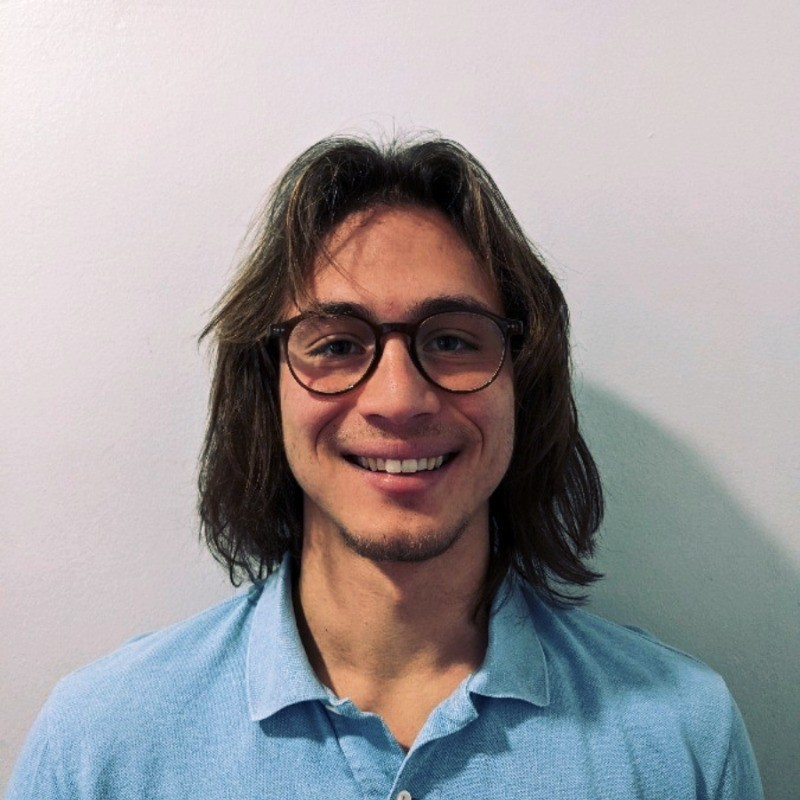

In [15]:
leo = linkedin_profile_extractor('https://www.linkedin.com/in/leonardo-pagliacci-12b145209/')
leo

### Import linkedin_api functions

In [6]:
# Import functions

%run linkedin_data_extractor_functions.ipynb

    
"""
    Functions:
    
    1.linkedin_profile_extractor(profile_url):
    
    Extracts detailed information from a LinkedIn profile given its URL.

    Args:
        profile_url (str): The URL of the LinkedIn profile.

    Returns:
        dict: A dictionary containing key information extracted from the LinkedIn profile, such as name, headline, experience, education, skills, etc.
        
    ---------------

    2.linkedin_job_description_extractor(job_url):
    
    Extracts key information from a LinkedIn job description given its URL.

    Args:
        job_url (str): The URL of the LinkedIn job posting.

    Returns:
        dict: A dictionary containing the extracted job description information, including the job title, company name, job location, and job responsibilities.
    
    ---------------
    

    3.linkedin_company_info_extractor(company_url):
    
    Extracts detailed information about a company from LinkedIn given its URL.

    Args:
        company_url (str): The URL of the company's LinkedIn page.

    Returns:
        dict: A dictionary containing key company information, such as company name, industry, size, and description, extracted from LinkedIn.
    
    ---------------
    
    4.linkedin_job_company_extractor(job_url):
    
    Extracts detailed information about a job and its posting company from LinkedIn based on the job's URL.

    Args:
        job_url (str): The URL of the LinkedIn job posting.

    Returns:
        dict: A dictionary that combines information extracted from the job description and the posting company's LinkedIn page. This includes job details and comprehensive company information.
"""




"\n    Functions:\n    \n    1.linkedin_profile_extractor(profile_url):\n    \n    Extracts detailed information from a LinkedIn profile given its URL.\n\n    Args:\n        profile_url (str): The URL of the LinkedIn profile.\n\n    Returns:\n        dict: A dictionary containing key information extracted from the LinkedIn profile, such as name, headline, experience, education, skills, etc.\n        \n    ---------------\n\n    2.linkedin_job_description_extractor(job_url):\n    \n    Extracts key information from a LinkedIn job description given its URL.\n\n    Args:\n        job_url (str): The URL of the LinkedIn job posting.\n\n    Returns:\n        dict: A dictionary containing the extracted job description information, including the job title, company name, job location, and job responsibilities.\n    \n    ---------------\n    \n\n    3.linkedin_company_info_extractor(company_url):\n    \n    Extracts detailed information about a company from LinkedIn given its URL.\n\n    Args:\

### Import prompt_engineering functions

In [7]:
# Import functions
%run prompt_engineering_linked_metrics.ipynb

"""
    Functions:
    
    1. pdf_to_resume_dict(pdf_path):
    
    Converts a PDF resume into a structured dictionary with standardized profile information.

    Args:
        pdf_path (str): The file path to the PDF document containing the resume.

    Returns:
        dict: A dictionary containing standardized profile information extracted from the resume.
        
    ---------------
   
    2. analyze_linkedin_profile(profile_dict):

    Analyzes a LinkedIn profile dictionary to return a structured JSON object with standardized profile information.

    Args:
        profile_dict (dict): A dictionary containing key information from a LinkedIn profile.

    Returns:
        dict: A JSON object with standardized profile information based on the analysis.
    
    ---------------
    

    3. analyze_linkedin_jd(jd_dict):
    
    Analyzes a LinkedIn job description (JD) to return a structured JSON object with standardized job and company information.

    Args:
        jd_dict (dict): A dictionary containing key information from a LinkedIn job description.

    Returns:
        dict: A JSON object with standardized job description and company information based on the analysis.
        
    ---------------
    

    4. job_matching_system(profile_json, jd_json):
    
    Analyzes the compatibility between a job seeker's profile and a job description, returning a JSON object with the compatibility analysis.

    Args:
        profile_json (dict): A JSON object containing standardized profile information of the job seeker.
        jd_json (dict): A JSON object containing standardized job description and company information.

    Returns:
        dict: A JSON object with the compatibility analysis, including scores and suggestions for improvement.
        
    
"""



ChallengeException: BAD_USERNAME_OR_PASSWORD

ChallengeException: BAD_USERNAME_OR_PASSWORD

### Test n.1

In [113]:
# Extracting Linkedin infos -> see the linkedin links for better understanding
vigno = linkedin_profile_extractor('https://www.linkedin.com/in/andrea-vignali-077ab9226/')
job = linkedin_job_company_extractor('https://www.linkedin.com/jobs/view/3829860721/?alternateChannel=search&refId=4QtpC7%2B%2Bd8hQ1O3XPaFXlA%3D%3D&trackingId=6IepS5pAMSTYZMS8f4qjyQ%3D%3D')



In [117]:
# Vigno's raw data
vigno

{'fullName': 'Andrea Vignali',
 'headline': 'Junior Software developer @ lab51',
 'summary': "Ho lavorato per 2 anni nell'officina di Boni motori marini da cui, oltre ad aver imparato la parte meccanica del lavoro, ho imparato come ci si rapporta col cliente per la vendita e l'assistenza.\n\nIn seguito ho iniziato un percorso di studi, per interesse personale, presso l'università di Bologna di Acquacoltura e Igiene delle produzioni ittiche.(attualmente ancora in corso)\nNel frattempo che completo gli studi, lavoro come Bagnino di Salvataggio presso la Dr Lifeguard di Cesenatico.Con la quale, oltre ad effettuare servizio in spiaggia, partecipo a manifestazioni sportive per la tutela degli atleti in mare.(Iron man- Swim&Run)\nStudio da tempo i linguaggi di programmazione per lo sviluppo Front-end di pagine web.\nMi piace viaggiare e scoprire nuove culture, praticare attività all'aria aperta e sport di squadra. Sono una persona attiva, sempre alla ricerca di stimoli e avventure a cui piac

In [119]:
# Job Description raw data
job

{'title': 'Sviluppatore Full Stack Web',
 'companyName': 'Antherica Srl',
 'companyURL': 'https://www.linkedin.com/company/antherica',
 'descriptionText': "Antherica Srl, attiva da 20 nel settore delle soluzioni digitali, è alla ricerca di un talentuoso Sviluppatore Full Stack Web per unirsi al nostro dinamico team di professionisti. Questa è un'opportunità eccezionale per lavorare in un ambiente stimolante e innovativo, dove le tue competenze saranno valorizzate e potrai contribuire attivamente allo sviluppo di applicazioni web all'avanguardia.\nRequisiti:Almeno 5 anni di esperienza comprovata nello sviluppo di applicazioni full stack (back end e front end) su architetture web.Competenze solide e approfondite in HTML, Javascript, CSS, PHP, e Jquery.Capacità di utilizzare la tua esperienza e buon senso come guida nelle decisioni di sviluppo e problem solving.\nCosa Offriamo:Un ruolo sfidante e ricco di soddisfazioni nello sviluppo di soluzioni proprietarie per medie e grandi imprese.La

In [114]:
# Analysis Likedin profile/job description -> profile/jd infos are processed and analyzed using OpenAI api
vigno_analysis = analyze_linkedin_profile(vigno)
job_analysis = analyze_linkedin_jd(job)

In [120]:
# Vigno's profile analyzed by OpenAI
vigno_analysis

{'Full Name': 'Andrea Vignali',
 'Location': 'Cesenatico, Emilia-Romagna, Italy',
 'Brief Overview': 'Andrea Vignali is a Junior Software Developer at lab51 with a background in web development, mechanical work, and lifeguarding. Currently pursuing studies in Aquaculture and Hygiene of Fish Productions at the University of Bologna. Enjoys programming, outdoor activities, and team sports.',
 'Degrees': {'Degree Type': 'High School Diploma',
  'Field of Study': '',
  'Institution': 'Liceo Scientifico Enzo Ferrari Cesenatico',
  'Graduation Date': 2014},
 'Hard Skills List': ['PHP',
  'Google Analytics',
  'SQL',
  'JavaScript',
  'WordPress',
  'React.js',
  'Front-end Development',
  'Mechanical Work'],
 'Soft Skills List': {'Introduction': 'Andrea Vignali possesses a diverse set of soft skills that complement their technical expertise:',
  'Skills': ['Team Spirit',
   'Problem-Solving',
   'Customer Relations',
   'Adaptability',
   'Active Learner']},
 'Strengths': {'Prominent Strengt

In [121]:
# Job Description analyzed by OpenAI
job_analysis

{'Job Title': 'Full Stack Web Developer',
 'Location': 'Reggio Emilia, Italy',
 'Job Description Overview': 'Seeking a talented Full Stack Web Developer with at least 5 years of experience in full stack application development using HTML, Javascript, CSS, PHP, and Jquery. The role involves working on proprietary solutions for medium and large enterprises, engaging in innovative projects with cutting-edge technologies, and contributing to the development of advanced web applications.',
 'Company Information': {'Company Name': 'Antherica Srl',
  'LinkedIn URL': 'https://www.linkedin.com/company/antherica',
  'Company Overview': "Antherica Srl focuses on providing innovative software tools to companies, professionals, and Public Institutions. They specialize in web application development, e-mail and SMS marketing, lead generation, web site development, and more. Antherica aims to be a leading reference for web-based technologies, offering customized solutions and services to enhance clie

In [115]:
# Compatibility Match System
match = job_matching_system(vigno_analysis,job_analysis)


In [122]:
# Compatibility Match analysis made by OpenAI
match

{'Overall Compatibility Score': 62,
 'Details': {'Skill Depth and Specialization': {'Match Status': 'Partial Match',
   'Percentage Match': 70,
   'Matched Skills': ['PHP', 'JavaScript', 'Front-end Development'],
   'Suggestions': 'Andrea should focus on enhancing skills in HTML, CSS, and Jquery to meet the full stack requirements of the role.'},
  'Experience Progression and Relevance': {'Match Status': 'Partial Match',
   'Percentage Match': 40,
   'Suggestions': 'Gaining more comprehensive experience in full stack development projects and reaching the 5-year experience mark will improve compatibility.'},
  'Educational Achievements and Specializations': {'Match Status': 'No Match',
   'Percentage Match': 0,
   'Suggestions': "Pursuing further education in Computer Science or a related field would significantly enhance Andrea's profile."},
  'Cultural Alignment and Soft Skills': {'Match Status': 'Match',
   'Percentage Match': 90,
   'Suggestions': "Continuing to develop leadership a

## To improve

- improve prompts in order to get standardize output and better results
- ????